#Object Detection with Fast RCNN




##Installing required packages

In [ ]:
import os 
from os.path import join
import sys
import matplotlib.pylab as plt
import cv2
import numpy as np

# Required packages/modules for Fast RCNN
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T

##Model and classes

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the class names given by PyTorch's official Docs
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table',
    'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush'
]



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

##Functions

In [ ]:

# Defining a function for get a prediction result from the model
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  img=np.array(img)
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  #print(pred)
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  #print("class", pred_class, "\n score", pred_score, "\n box", pred_boxes )
  if sum(i > threshold for i in pred_score)>=1:
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    #to have 2 boxes at least we put +2
    pred_boxes = pred_boxes[:pred_t+4]
    pred_class = pred_class[:pred_t+4]
    pred_score = pred_score[:pred_t+4]
    #print("found")
    #print("boxes:",pred_boxes)
    #print("scores:",pred_score)
    
  else:
    #print("no found")
    #print("boxes:",pred_boxes)
    #print("scores:",pred_score)
    #to have 2 boxes at least we put :2
    pred_boxes = pred_boxes[:4]
    pred_class = pred_class[:4]
    pred_score = pred_score[:4]
  
  return pred_boxes, pred_class, pred_score, pred


  # Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls, pred_sc, pred  = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  #plt.figure(figsize=(15,20)) # display the output image
  #plt.imshow(img)
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()
  return boxes, pred_cls, pred_sc, pred

In [ ]:
def iou(boxes_f,pred_sc_f,thresh_iou):
  #IoU
  #create tensor_f 
  tensorf=[]
  nf=0
  for i in boxes_f:   
    a1,a2,a3,a4= int(i[0][0]), int(i[0][1]), int(i[1][0]), int(i[1][1]) 
    a5=round(pred_sc_f[nf],3)
    nf=nf+1
    #print(x1,x2,x3,x4,x5)
    tensorf.append([a1,a2,a3,a4,a5])
  #print(tensorf)
  #make it good format
  tensor_f= torch.tensor(tensorf)
  tensor_f

  # we extract coordinates for every prediction box present in P
  x1 = tensor_f[:, 0]
  y1 = tensor_f[:, 1]
  x2 = tensor_f[:, 2]
  y2 = tensor_f[:, 3]
  scores = tensor_f[:, 4] #confidence scores as well
  # calculate area of every block in P
  areas = (x2 - x1) * (y2 - y1)
  # sort the prediction boxes in P according to their confidence scores
  order = scores.argsort()
  # initialise an empty list for filtered prediction boxes
  keep_f = []    
  while len(order) > 0:
    # extract  index of the prediction with highest score (prediction S)
    idx = order[-1]
    # push S in filtered predictions list
    keep_f.append(tensor_f[idx])
    # remove S from P
    order = order[:-1]
    # sanity check
    if len(order) == 0:
      break
        
    # select coordinates of BBoxes according to the indices in order
    xx1 = torch.index_select(x1,dim = 0, index = order)
    xx2 = torch.index_select(x2,dim = 0, index = order)
    yy1 = torch.index_select(y1,dim = 0, index = order)
    yy2 = torch.index_select(y2,dim = 0, index = order)
    # find the coordinates of the intersection boxes
    xx1 = torch.max(xx1, x1[idx])
    yy1 = torch.max(yy1, y1[idx])
    xx2 = torch.min(xx2, x2[idx])
    yy2 = torch.min(yy2, y2[idx])
    # find height and width of the intersection boxes
    w = xx2 - xx1
    h = yy2 - yy1
    # take max with 0.0 to avoid negative w and h due to non-overlapping boxes
    w = torch.clamp(w, min=0.0)
    h = torch.clamp(h, min=0.0)
    # find the intersection area
    inter = w*h
    # find the areas of BBoxes according the indices in order
    rem_areas = torch.index_select(areas, dim = 0, index = order) 
    # find the union of every prediction T in P with the prediction S
    # Note that areas[idx] represents area of S
    union = (rem_areas - inter) + areas[idx]
    # find the IoU of every prediction in P with S
    IoU = inter / union
    # keep the boxes with IoU less than thresh_iou
    mask = IoU < thresh_iou
    order = order[mask]
  return keep_f  
  #print("keep_f es",keep_f)

In [ ]:
def two_bb(keep_f):
  #reduce keep_f to 2 boxes
  final_box = []  
  if len(keep_f)<=2:
    #print("break before because 2 or less boxes were found")
    final_box=keep_f
    #print(keep_f)
  else:
    #print("we need to reduce keep_f to 2 boxes")
    #get 2 boxes with more areas
    boxes=[]
    areas=[]
    for i in keep_f:   
      a1,a2,a3,a4= int(i[0]), int(i[1]), int(i[2]), int(i[3]) 
      print(a1,a2,a3,a4)
      a5 =float(i[4])
      area = (a3 - a1) * (a4 - a2)
      boxes.append([a1,a2,a3,a4])
      areas.append(area)
    #print(boxes)
    #print(areas)

    #order according areas
    order=np.argsort(areas)
    while len(order) > 0:
      # extract  index of the prediction with highest score (prediction S)
      idx = order[-1]
      #print(idx)
      # push S in filtered predictions list
      final_box.append(boxes[idx])
      # remove S from P
      order = order[:-1]
      # sanity check
      if len(order) == 0:
        break

  final_box=final_box[:2]
  return final_box

In [ ]:
  def plot_ffbb(imcv,final_box):
  
    #PLOT THE Final Boxes
    #imcv = cv2.imread("b.jpg") # Read image with cv2
    imcv = cv2.cvtColor(imcv, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(final_box)):
      print(final_box)
      start= (int(final_box[i][0]), int(final_box[i][1]))
      end  = (int(final_box[i][2]), int(final_box[i][3]))
      color= (0, 255, 0)
      cv2.rectangle(imcv, start, end , (0, 255, 0), 5) # Draw Rectangle with the coordinates
      #cv2.putText(imcv, str(keep_f[i][4]), start,  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3) 
      # Write the prediction score, text_size=1.5 , thickness=3
    plt.figure(figsize=(15,20)) # display the output image
    plt.imshow(imcv)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    top= final_box
    return

In [ ]:
def get_MLW(top, side):
  #IDENTIFY REFERENCE OBJECT AS THE ONE IN THE RIGHT!
  if int(top[0][0])> int(top[1][0]) and int(top[0][2])> int(top[1][2]):
    ref_obj =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
    obj     =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])
  else:
    obj     =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
    ref_obj =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])


  #real ref object dimensions:
  L_rro= 30.4
  H_rro= 12.6
  W_rro= 9

  if side=="front":
    L1_ro= ref_obj[2]-ref_obj[0]
    L1_ob=     obj[2]-    obj[0]
    H_ro = ref_obj[3]-ref_obj[1]
    H_ob =     obj[3]-    obj[1]
    #calculate L1 H
    px1= round(L_rro/L1_ro,3)
    L1= round(L1_ob * px1,3)
    px2=round(H_rro/H_ro,3)
    H= round(H_ob * px2,3)
    #EVALUATE IF ITS BETTER TO AVERAGE OF PX1 AND PX2

    return L1, H

  if side=="side":
    L2_ro= ref_obj[2]-ref_obj[0]
    L2_ob=     obj[2]-    obj[0]
    W_ro = ref_obj[3]-ref_obj[1]
    W_ob =     obj[3]-    obj[1]
    #calculate L2 W
    px1= round(L_rro/L2_ro,3)
    L2= round(L2_ob * px1,3)
    px2=round(W_rro/W_ro,3)
    W= round(W_ob * px2,3)
    #print(px,px2)
    #print("L=",L,"W=",W)

    return L2, W

In [ ]:
def run(imf,imfcv, ims, imscv, thresh_iou):
  boxes_f, pred_cls_f, pred_sc_f, pred_f = object_detection_api(imf, threshold=0.8)
  boxes_s, pred_cls_s, pred_sc_s, pred_s = object_detection_api(ims, threshold=0.8)
  keep_f = iou(boxes_f, pred_sc_f,thresh_iou)
  keep_s = iou(boxes_s, pred_sc_s,thresh_iou)
  final_box_f = two_bb(keep_f)
  final_box_s = two_bb(keep_s)
  print("here")
  L1, H = get_MLW(final_box_f, "front")
  L2, W = get_MLW(final_box_s, "side")
  LF= (L1+L2)/2
  img_pred_1= plot_ffbb(imfcv,final_box_f)
  img_pred_2= plot_ffbb(imscv,final_box_s)
  return final_box_f, final_box_s, L1, L2, LF, H, W

## Detections

here
[tensor([2.0200e+02, 5.7000e+01, 1.8300e+03, 1.1580e+03, 7.9900e-01]), tensor([1.9740e+03, 4.6900e+02, 3.4740e+03, 1.1040e+03, 6.2600e-01])]
[tensor([2.0200e+02, 5.7000e+01, 1.8300e+03, 1.1580e+03, 7.9900e-01]), tensor([1.9740e+03, 4.6900e+02, 3.4740e+03, 1.1040e+03, 6.2600e-01])]


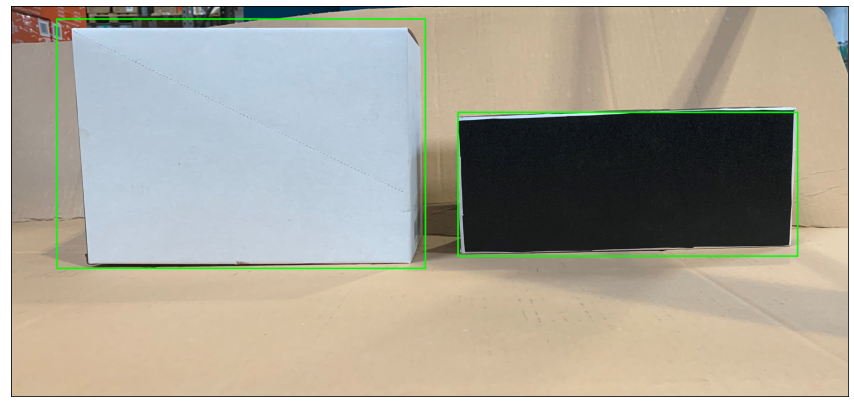

[tensor([5.0900e+02, 8.3400e+02, 1.8140e+03, 1.4840e+03, 6.4100e-01]), tensor([1.9120e+03, 8.9900e+02, 3.1810e+03, 1.2710e+03, 3.7000e-01])]
[tensor([5.0900e+02, 8.3400e+02, 1.8140e+03, 1.4840e+03, 6.4100e-01]), tensor([1.9120e+03, 8.9900e+02, 3.1810e+03, 1.2710e+03, 3.7000e-01])]


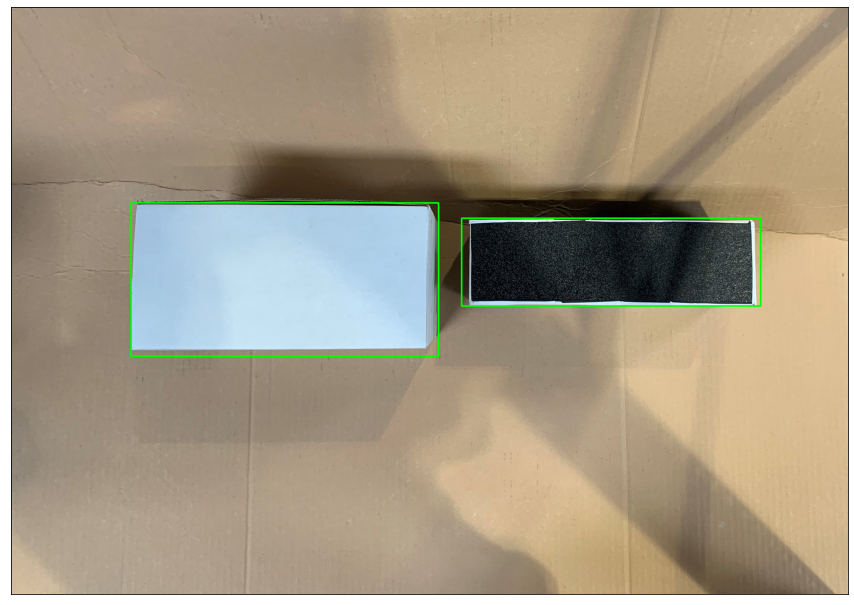

32.56 31.32 31.94 22.02 16


In [ ]:
#lets detect
imf = "/content/test/NXSide3m.jpg"
imfcv = cv2.imread(imf)
ims = "/content/test/NXTop3m.jpg"
imscv = cv2.imread(ims)
boxf, boxs, l1, l2, lf, h ,w =run(imf,imfcv, ims, imscv ,0.8)
print(l1, l2, lf, h ,w)

no found


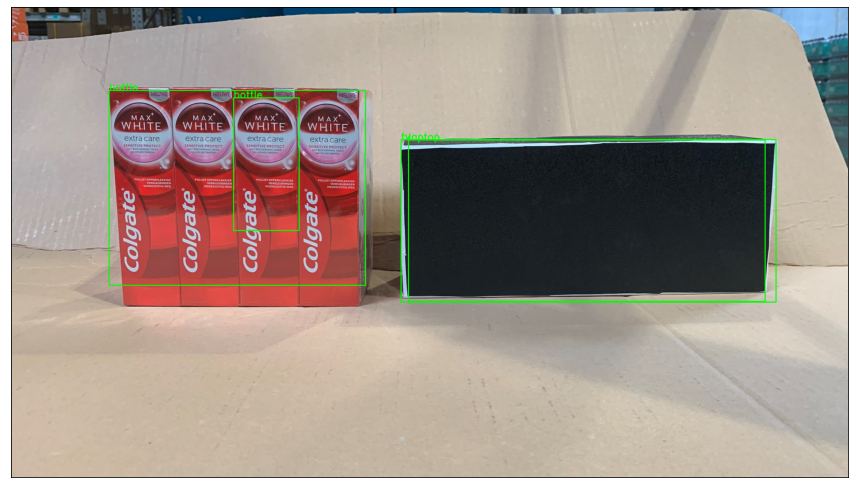

no found


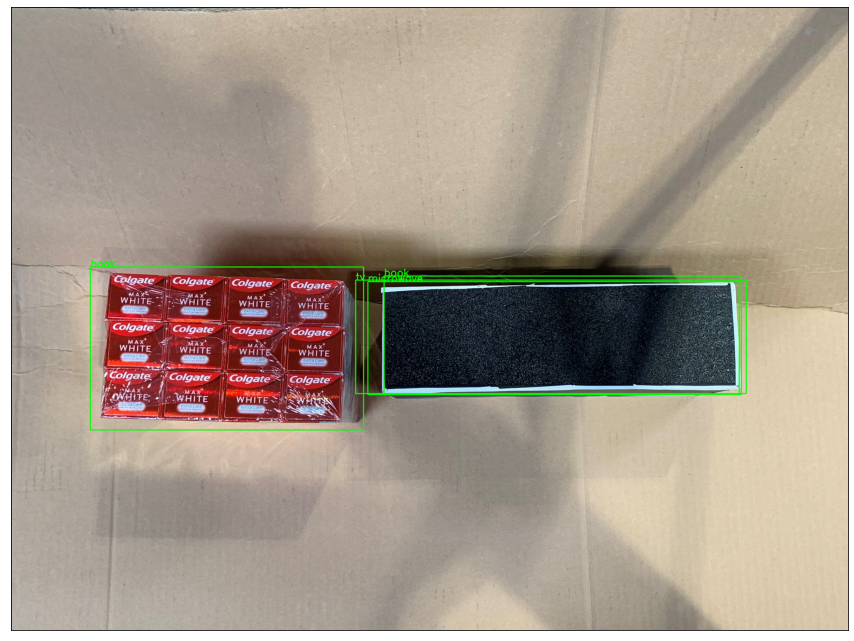

we need to reduce keep_f to 2 boxes
1019 420 1319 1027
1820 613 3453 1352
449 386 1623 1278
break before because 2 or less boxes were found
here
[[1820, 613, 3453, 1352], [449, 386, 1623, 1278]]
[[1820, 613, 3453, 1352], [449, 386, 1623, 1278]]


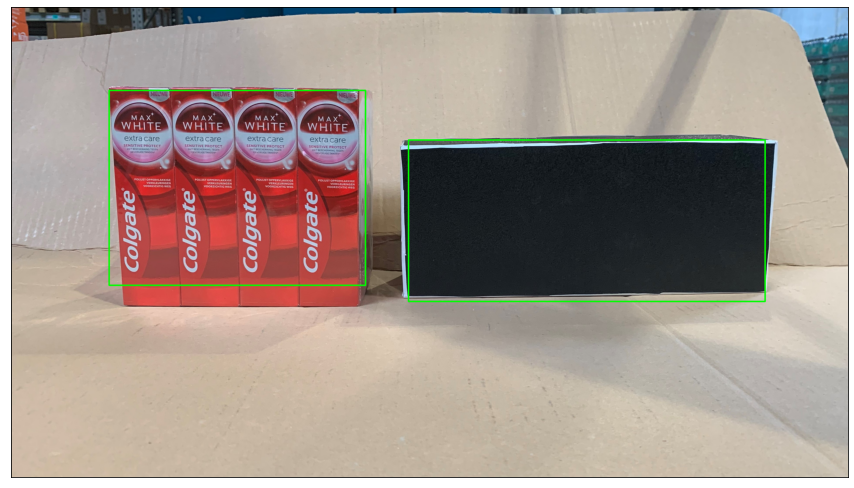

[tensor([3.5200e+02, 1.1560e+03, 1.5640e+03, 1.8780e+03, 6.7600e-01]), tensor([1.5290e+03, 1.2140e+03, 3.2620e+03, 1.7170e+03, 5.2400e-01])]
[tensor([3.5200e+02, 1.1560e+03, 1.5640e+03, 1.8780e+03, 6.7600e-01]), tensor([1.5290e+03, 1.2140e+03, 3.2620e+03, 1.7170e+03, 5.2400e-01])]


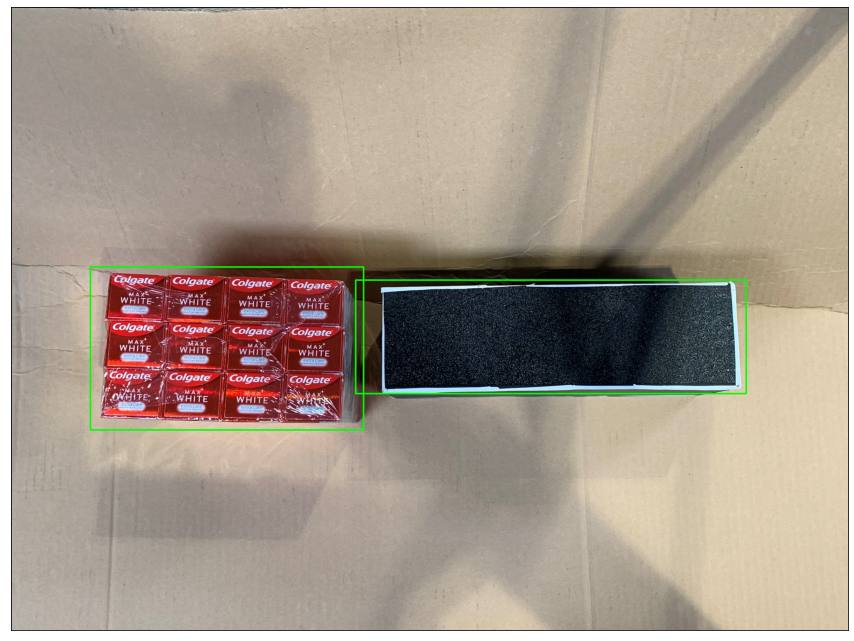

22.306 21.816 15.164 13


In [ ]:
#lets detect 22   
imf = "/content/test/GXSide2m.jpg"
imfcv = cv2.imread(imf)
ims = "/content/test/GXTop3m.jpg"
imscv = cv2.imread(ims)
boxf, boxs, l1, l2, h ,w =run(imf,imfcv, ims, imscv ,0.8)
print(l1, l2, h ,w)

In [ ]:
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())

In [ ]:
def detect(imf,imcv, thresh_iou):
  #object detection
  boxes_f, pred_cls_f, pred_sc_f, pred_f = object_detection_api(imf, threshold=0.8)
  #print("boxes_f es",boxes_f)
#-----------------
  #IoU
  #create tensor_f 
  tensorf=[]
  nf=0
  for i in boxes_f:   
    a1,a2,a3,a4= int(i[0][0]), int(i[0][1]), int(i[1][0]), int(i[1][1]) 
    a5=round(pred_sc_f[nf],3)
    nf=nf+1
    #print(x1,x2,x3,x4,x5)
    tensorf.append([a1,a2,a3,a4,a5])
  #print(tensorf)
  #make it good format
  tensor_f= torch.tensor(tensorf)
  tensor_f

  # we extract coordinates for every prediction box present in P
  x1 = tensor_f[:, 0]
  y1 = tensor_f[:, 1]
  x2 = tensor_f[:, 2]
  y2 = tensor_f[:, 3]
  scores = tensor_f[:, 4] #confidence scores as well
  # calculate area of every block in P
  areas = (x2 - x1) * (y2 - y1)
  # sort the prediction boxes in P according to their confidence scores
  order = scores.argsort()
  # initialise an empty list for filtered prediction boxes
  keep_f = []    
  while len(order) > 0:
    # extract  index of the prediction with highest score (prediction S)
    idx = order[-1]
    # push S in filtered predictions list
    keep_f.append(tensor_f[idx])
    # remove S from P
    order = order[:-1]
    # sanity check
    if len(order) == 0:
      break
        
    # select coordinates of BBoxes according to the indices in order
    xx1 = torch.index_select(x1,dim = 0, index = order)
    xx2 = torch.index_select(x2,dim = 0, index = order)
    yy1 = torch.index_select(y1,dim = 0, index = order)
    yy2 = torch.index_select(y2,dim = 0, index = order)
    # find the coordinates of the intersection boxes
    xx1 = torch.max(xx1, x1[idx])
    yy1 = torch.max(yy1, y1[idx])
    xx2 = torch.min(xx2, x2[idx])
    yy2 = torch.min(yy2, y2[idx])
    # find height and width of the intersection boxes
    w = xx2 - xx1
    h = yy2 - yy1
    # take max with 0.0 to avoid negative w and h due to non-overlapping boxes
    w = torch.clamp(w, min=0.0)
    h = torch.clamp(h, min=0.0)
    # find the intersection area
    inter = w*h
    # find the areas of BBoxes according the indices in order
    rem_areas = torch.index_select(areas, dim = 0, index = order) 
    # find the union of every prediction T in P with the prediction S
    # Note that areas[idx] represents area of S
    union = (rem_areas - inter) + areas[idx]
    # find the IoU of every prediction in P with S
    IoU = inter / union
    # keep the boxes with IoU less than thresh_iou
    mask = IoU < thresh_iou
    order = order[mask]
#    return keep_f  
  #print("keep_f es",keep_f)

#--------  
  #reduce keep_f to 2 boxes
  final_box = []  
  if len(keep_f)>2:
    print("we need to reduce keep_f to 2 boxes")
    #get 2 boxes with more areas
    boxes=[]
    areas=[]
    for i in keep_f:   
      a1,a2,a3,a4= int(i[0]), int(i[1]), int(i[2]), int(i[3]) 
      print(a1,a2,a3,a4)
      a5 =float(i[4])
      area = (a3 - a1) * (a4 - a2)
      boxes.append([a1,a2,a3,a4])
      areas.append(area)
    #print(boxes)
    #print(areas)

    #order according areas
    order=np.argsort(areas)
    while len(order) > 0:
      # extract  index of the prediction with highest score (prediction S)
      idx = order[-1]
      #print(idx)
      # push S in filtered predictions list
      final_box.append(boxes[idx])
      # remove S from P
      order = order[:-1]
      # sanity check
      if len(order) == 0:
        break
  else:
    #print("break before because 2 or less boxes were found")
    final_box=keep_f
    #print(keep_f)

  final_box=final_box[:2]

#--------  
  #PLOT THE Final Boxes
  #imcv = cv2.imread("b.jpg") # Read image with cv2
  imcv = cv2.cvtColor(imcv, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(final_box)):
    #print(final_box)
    start= (int(final_box[i][0]), int(final_box[i][1]))
    end  = (int(final_box[i][2]), int(final_box[i][3]))
    color= (0, 255, 0)
    cv2.rectangle(imcv, start, end , (0, 255, 0), 5) # Draw Rectangle with the coordinates
    #cv2.putText(imcv, str(keep_f[i][4]), start,  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3) 
    # Write the prediction score, text_size=1.5 , thickness=3
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(imcv)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  top= final_box
#-------- 
  #IDENTIFY REFERENCE OBJECT AS THE ONE IN THE RIGHT!
  if int(top[0][0])> int(top[1][0]) and int(top[0][2])> int(top[1][2]):
    ref_obj =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
    obj     =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])
  else:
    obj     =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
    ref_obj =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])



  L_ro= ref_obj[2]-ref_obj[0]
  L_ob=     obj[2]-    obj[0]
  W_ro = ref_obj[3]-ref_obj[1]
  W_ob =     obj[3]-    obj[1]

  print("ref obj:", L_ro, W_ro)
  print("object :", L_ob, W_ob)

  px= round(30.4/L_ro,3)
  L= L_ob * px
  px2=round(12.6/W_ro,3)
  W= W_ob * px2
  print(px,px2)
  print("L=",L,"W=",W)

  return final_box, L, W

found


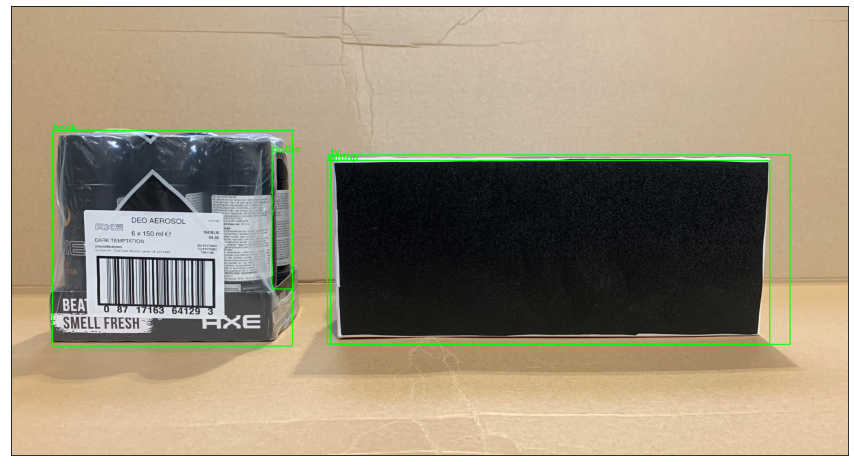

boxes_f es [[(1219.6884, 681.6735), (1316.5935, 1321.6743)], [(1493.781, 695.28784), (3639.6587, 1580.803)], [(1478.5615, 721.41113), (3544.686, 1578.0802)], [(194.75992, 582.0651), (1315.35, 1588.0078)]]
keep_f es [tensor([1.2190e+03, 6.8100e+02, 1.3160e+03, 1.3210e+03, 8.5400e-01]), tensor([1.4930e+03, 6.9500e+02, 3.6390e+03, 1.5800e+03, 5.9700e-01]), tensor([1.9400e+02, 5.8200e+02, 1.3150e+03, 1.5880e+03, 3.5400e-01])]
we need to reduce keep_f to 2 boxes
1219 681 1316 1321
1493 695 3639 1580
194 582 1315 1588
[[1493, 695, 3639, 1580], [194, 582, 1315, 1588]]
[[1493, 695, 3639, 1580], [194, 582, 1315, 1588]]


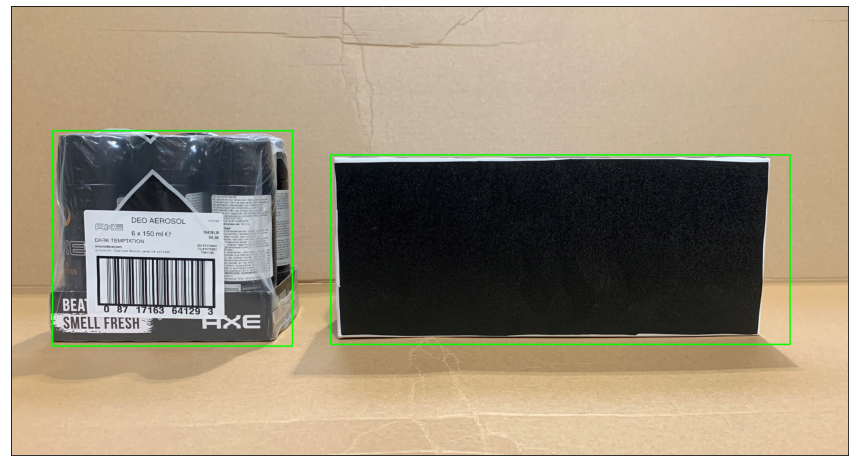

ref obj: 2146 885
object : 1121 1006
0.014 0.014
L= 15.694 W= 14.084


In [ ]:
#lets detect
img = "a.jpg"
imcv = cv2.imread('a.jpg')
kk=detect(img,imcv,0.8)


no found


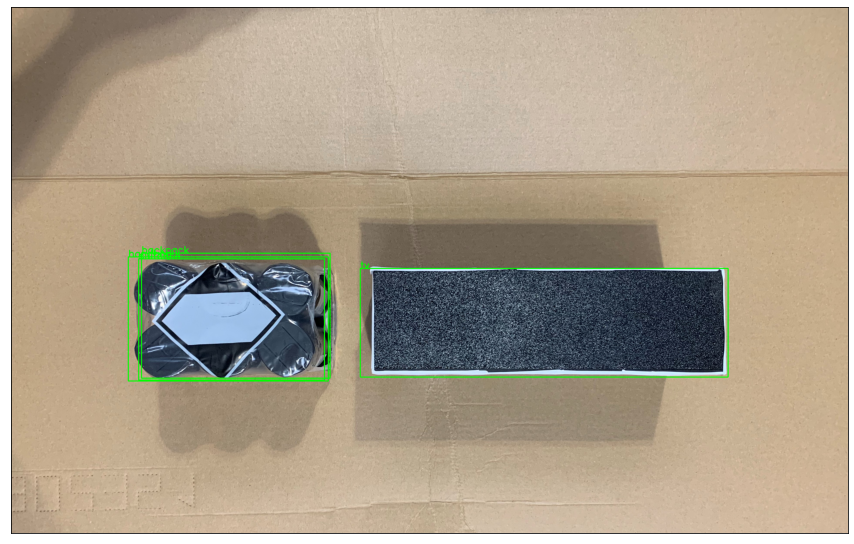

boxes_f es [[(1609.0815, 1207.4904), (3304.0469, 1707.7814)], [(540.105, 1154.9907), (1462.2113, 1725.2892)], [(601.9535, 1137.9751), (1470.2145, 1712.7312)], [(588.06396, 1163.1421), (1444.78, 1721.4402)]]
keep_f es [tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]
break before because 2 or less boxes were found
[tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]
[tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]
[tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]


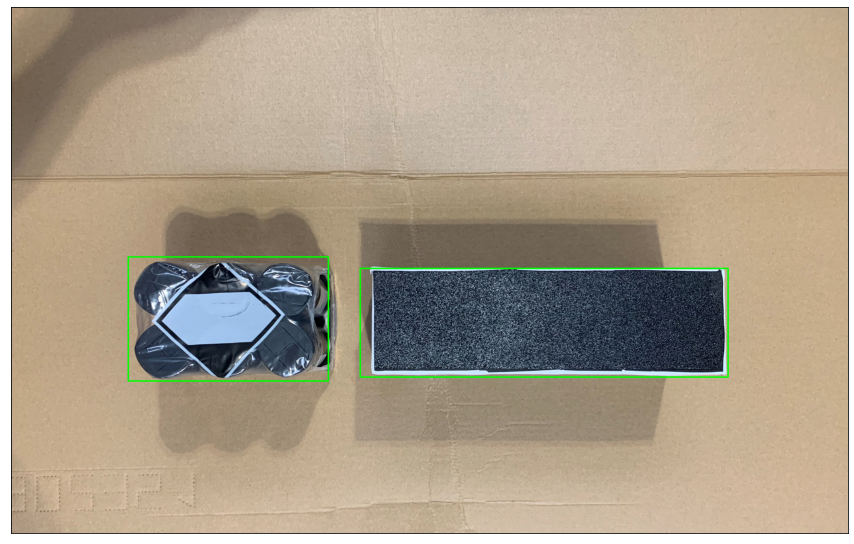

In [ ]:
#lets detect
img = "b.jpg"
imcv = cv2.imread('b.jpg')
top=detect(img,imcv,0.8)

In [ ]:

#IDENTIFY REFERENCE OBJECT AS THE ONE IN THE RIGHT!
if int(top[0][0])> int(top[1][0]) and int(top[0][2])> int(top[1][2]):
  ref_obj =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
  obj     =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])
else:
  obj     =int(top[0][0]),int(top[0][1]),int(top[0][2]),int(top[0][3])
  ref_obj =int(top[1][0]),int(top[1][1]),int(top[1][2]),int(top[1][3])



L_ro= ref_obj[2]-ref_obj[0]
L_ob=     obj[2]-    obj[0]
W_ro = ref_obj[3]-ref_obj[1]
W_ob =     obj[3]-    obj[1]

print("ref obj:", L_ro, L_ro)
print("object :", L_ob, L_ob)

px= round(30.4/L_ro,3)
L= L_ob * px
px2=round(12.6/W_ro,3)
W= W_ob * px2
print(px,px2)
print(L,W)

ref obj: 1695 500
object : 922 571
0.018 0.025
16.596 14.275


1219 681 1316 1321
1493 695 3639 1580
194 582 1315 1588
[[1493, 695, 3639, 1580], [194, 582, 1315, 1588]]
[[1493, 695, 3639, 1580], [194, 582, 1315, 1588]]


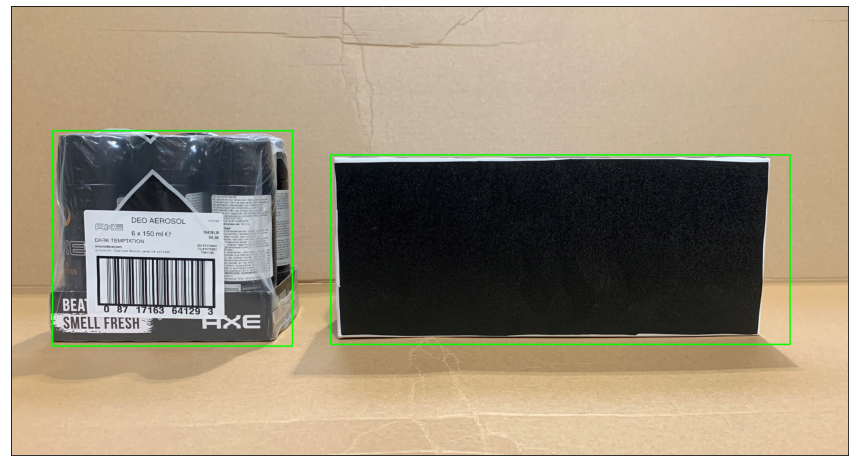

In [ ]:
#get 2 boxes with more areas

boxes=[]
areas=[]
for i in kk:   
  a1,a2,a3,a4= int(i[0]), int(i[1]), int(i[2]), int(i[3]) 
  print(a1,a2,a3,a4)
  a5 =float(i[4])
  area = (a3 - a1) * (a4 - a2)
  boxes.append([a1,a2,a3,a4])
  areas.append(area)
#print(boxes)
#print(areas)

#order according areas
order=np.argsort(areas)
order
final_box = []    
while len(order) > 0:
  # extract  index of the prediction with highest score (prediction S)
  idx = order[-1]
  #print(idx)
  # push S in filtered predictions list
  final_box.append(boxes[idx])
  # remove S from P
  order = order[:-1]
  # sanity check
  if len(order) == 0:
    break

final_box=final_box[:-1]

#PLOT THE Final Boxes
#imcv = cv2.imread("b.jpg") # Read image with cv2
imcv = cv2.cvtColor(imcv, cv2.COLOR_BGR2RGB) # Convert to RGB
for i in range(len(final_box)):
  print(final_box)
  start= (int(final_box[i][0]), int(final_box[i][1]))
  end  = (int(final_box[i][2]), int(final_box[i][3]))
  color= (0, 255, 0)
  cv2.rectangle(imcv, start, end , (0, 255, 0), 5) # Draw Rectangle with the coordinates
  #cv2.putText(imcv, str(keep_f[i][4]), start,  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3) 
  # Write the prediction score, text_size=1.5 , thickness=3
plt.figure(figsize=(15,20)) # display the output image
plt.imshow(imcv)
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
final_box

[[1493, 695, 3639, 1580], [194, 582, 1315, 1588], [1219, 681, 1316, 1321]]

In [ ]:



  order = scores.argsort()
  # initialise an empty list for filtered prediction boxes
  keep_f = []    
  while len(order) > 0:
    # extract  index of the prediction with highest score (prediction S)
    idx = order[-1]
    # push S in filtered predictions list
    keep_f.append(tensor_f[idx])
    # remove S from P
    order = order[:-1]
    # sanity check
    if len(order) == 0:
      break


array([1, 2, 0])

In [ ]:
boxes

[[1219, 681, 1316, 1321], [1493, 695, 3639, 1580], [194, 582, 1315, 1588]]

In [ ]:


import torch
from torchvision.ops import nms
boxes = torch.tensor(boxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)
nms(boxes = boxes, scores = scores, iou_threshold=0.01)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([0, 1])

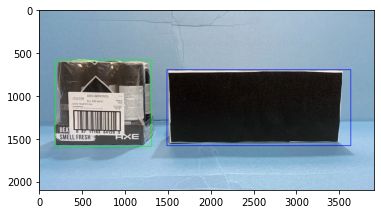

In [ ]:
start1=(194, 582)
start2=(1493, 695)
end1=(1315, 1588)
end2=(3639, 1580)
image=cv2.imread("a.jpg")
cv2.rectangle(image, start1, end1 ,(0, 255, 0), 5)
cv2.rectangle(image, start2, end2 ,(0, 0, 255), 5)
plt.imshow(image)

no found


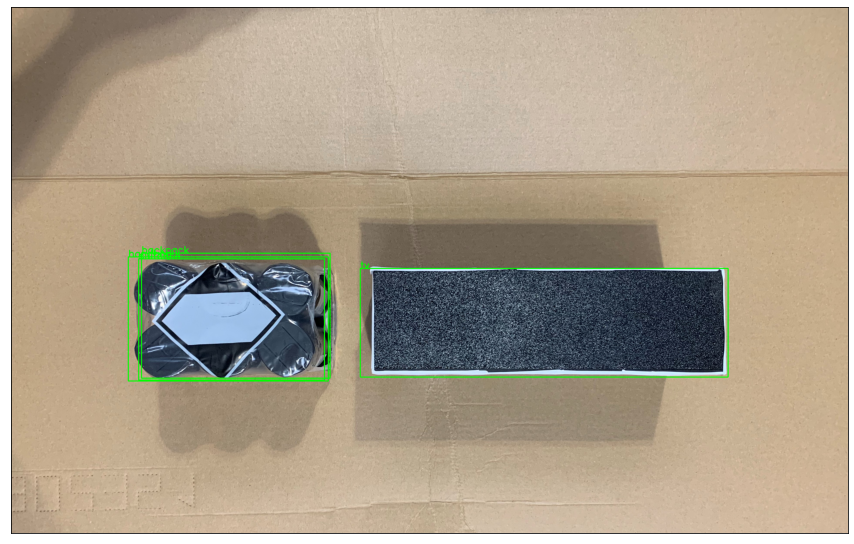

[tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]
[tensor([1.6090e+03, 1.2070e+03, 3.3040e+03, 1.7070e+03, 3.2600e-01]), tensor([5.4000e+02, 1.1540e+03, 1.4620e+03, 1.7250e+03, 2.6200e-01])]


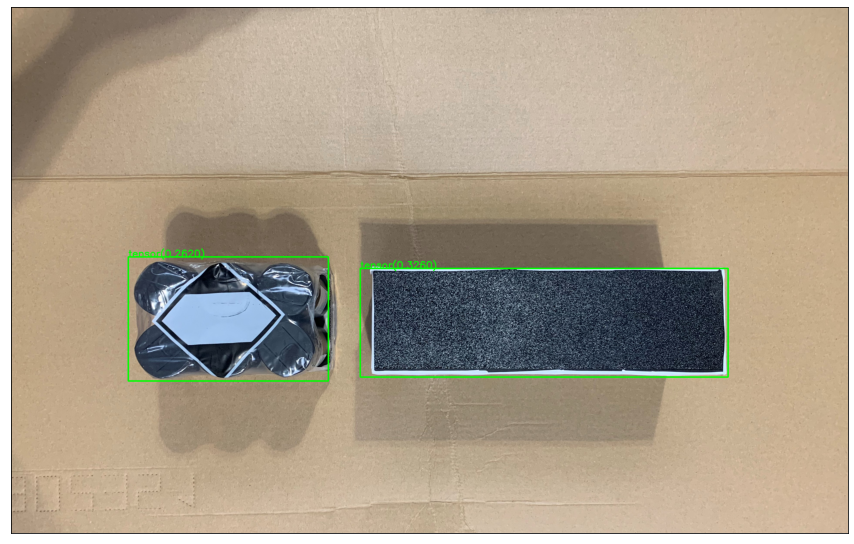

In [ ]:
#lets detect
img = "b.jpg"
imcv = cv2.imread('b.jpg')
k=detect(img,imcv,0.8)

In [ ]:
kk

NameError: ignored

In [ ]:
#get points and score AUTOMATE
#MANUAL
#box_try = torch.tensor([
#    [1219, 681, 1316, 1321, 0.85404104],
#    [1493.781, 695, 3639, 1580, 0.59],
#    [1478, 721, 3544, 1578, 0.47],
#    [194, 582, 1315, 1588, 0.35]
#])


tensor=[]
n=0
for i in boxes_f:
  
  #print(int(i[1][1]))
  x1,x2,x3,x4= int(i[0][0]), int(i[0][1]), int(i[1][0]), int(i[1][1]) 
  x5=round(pred_sc_f[n],3)
  n=n+1
  #print(x1,x2,x3,x4,x5)
  tensor.append([x1,x2,x3,x4,x5])

print(tensor)

#make it good
tensor_f= torch.tensor(tensor)

[[1219, 681, 1316, 1321, 0.854], [1493, 695, 3639, 1580, 0.597], [1478, 721, 3544, 1578, 0.467], [194, 582, 1315, 1588, 0.354], [451, 580, 1291, 1532, 0.155], [1152, 607, 1305, 1343, 0.136], [1004, 626, 1308, 1440, 0.095], [180, 546, 1334, 1568, 0.083], [1443, 692, 3550, 1571, 0.08], [205, 535, 1313, 1548, 0.066]]


tensor([[1.2190e+03, 6.8100e+02, 1.3160e+03, 1.3210e+03, 8.5400e-01],
        [1.4930e+03, 6.9500e+02, 3.6390e+03, 1.5800e+03, 5.9700e-01],
        [1.4780e+03, 7.2100e+02, 3.5440e+03, 1.5780e+03, 4.6700e-01],
        [1.9400e+02, 5.8200e+02, 1.3150e+03, 1.5880e+03, 3.5400e-01],
        [4.5100e+02, 5.8000e+02, 1.2910e+03, 1.5320e+03, 1.5500e-01],
        [1.1520e+03, 6.0700e+02, 1.3050e+03, 1.3430e+03, 1.3600e-01],
        [1.0040e+03, 6.2600e+02, 1.3080e+03, 1.4400e+03, 9.5000e-02],
        [1.8000e+02, 5.4600e+02, 1.3340e+03, 1.5680e+03, 8.3000e-02],
        [1.4430e+03, 6.9200e+02, 3.5500e+03, 1.5710e+03, 8.0000e-02],
        [2.0500e+02, 5.3500e+02, 1.3130e+03, 1.5480e+03, 6.6000e-02]])

## Interseccion over Union (IoU)
read https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/

In [ ]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import dlib
import sys
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Load our image again
image_front = cv2.imread("a.jpg")
copy_f = image_front.copy()


In [ ]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    scores = P[:, 4]
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
    # sort the prediction boxes in P according to their confidence scores
    order = scores.argsort()
    # initialise an empty list for filtered prediction boxes
    keep = []
    
    while len(order) > 0:
        # extract the index of the prediction with highest score 
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep

In [ ]:
	filtered_boxes = nms_pytorch(tensor_f,0.6)


In [ ]:
filtered_boxes

[tensor([1.2190e+03, 6.8100e+02, 1.3160e+03, 1.3210e+03, 8.5400e-01]),
 tensor([1.4930e+03, 6.9500e+02, 3.6390e+03, 1.5800e+03, 5.9700e-01]),
 tensor([1.9400e+02, 5.8200e+02, 1.3150e+03, 1.5880e+03, 3.5400e-01]),
 tensor([1.1520e+03, 6.0700e+02, 1.3050e+03, 1.3430e+03, 1.3600e-01]),
 tensor([1.0040e+03, 6.2600e+02, 1.3080e+03, 1.4400e+03, 9.5000e-02])]

In [ ]:
mask

tensor([True])

In [ ]:
order

tensor([], dtype=torch.int64)

1219 681 1316 1321 0
1493 695 3639 1580 0
194 582 1315 1588 0
1152 607 1305 1343 0
1004 626 1308 1440 0


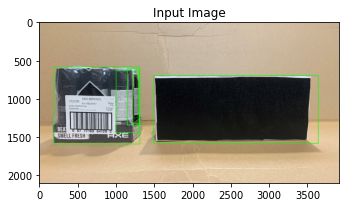

In [ ]:
img_fp = cv2.imread("a.jpg")
box_fin=[]
for i in filtered_boxes:
  x1, x2, x3, x4,p =int(i[0]), int(i[1]), int(i[2]), int(i[3]), int(i[4])
  print(x1,x2,x3,x4,p)
  start= (x1,x2)
  end=(x3,x4)
  cv2.rectangle(img_fp, start, end ,(0, 255, 0), 5)
#x1, x2, x3, x4 =int(filtered_boxes[0][0]), int(filtered_boxes[0][1]), int(filtered_boxes[0][3]), int(filtered_boxes[0][4])
imshow("Input Image", img_fp)

In [ ]:
x1, y1, x2, y2 = int(boxes_s[0][0][0]), int(boxes_s[0][0][1]), int(boxes_s[0][1][0]), int(boxes_s[0][1][1])
x3, y3, x4, y4 = int(boxes_s[1][0][0]), int(boxes_s[1][0][1]), int(boxes_s[1][1][0]), int(boxes_s[1][1][1])
start = (x1, y1)
end = (x2, y2)
start2 = (x3, y3)
end2 = (x4, y4)
print(start,end)

# Format is X,Y,W,H
rect = (x1,y1,x2-x1,y2-y1)
rect2 = (x3,y3,x4-x3,y4-y3)

# Show Rectangle
cv2.rectangle(img_fp, start, end, (0,0,255), 3)
cv2.rectangle(copy_s, start2, end2, (0,0,255), 3)
imshow("Input Image", copy_s)

(1609, 1207) (3304, 1707)


TypeError: ignored

In [ ]:
#@save
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clip(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## 30. GrabCut Algorithm for Background Removal

In [ ]:
print(int(boxes[1][0][0]), int(boxes[1][0][1]), int(boxes[1][1][0]), int(boxes[1][1][1]))

540 1154 1462 1725


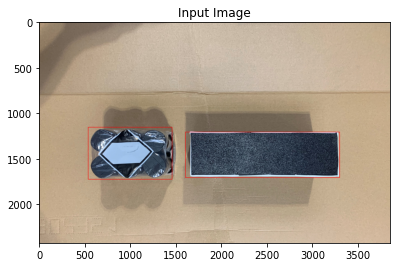

In [ ]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import dlib
import sys
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Load our image
image_front = cv2.imread(img_fp)
image_side =  cv2.imread(img_sp)
copy_f = image_front.copy()
copy_s = image_side.copy()
# Create a mask (of zeros uint8 datatype) that is the same size (width, height) as our original image 
#
mask_s = np.zeros(image_side.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# Needs to be set Manually or selected with cv2.selectROI()
#x1, y1, x2, y2 = 1609, 1207, 3304, 1707
#x3, y3, x4, y4 = 540, 1154, 1462, 1725
x1, y1, x2, y2 = int(boxes_s[0][0][0]), int(boxes_s[0][0][1]), int(boxes_s[0][1][0]), int(boxes_s[0][1][1])
x3, y3, x4, y4 = int(boxes_s[1][0][0]), int(boxes_s[1][0][1]), int(boxes_s[1][1][0]), int(boxes_s[1][1][1])
start = (x1, y1)
end = (x2, y2)
start2 = (x3, y3)
end2 = (x4, y4)

# Format is X,Y,W,H
rect = (x1,y1,x2-x1,y2-y1)
rect2 = (x3,y3,x4-x3,y4-y3)

# Show Rectangle
cv2.rectangle(copy_s, start, end, (0,0,255), 3)
cv2.rectangle(copy_s, start2, end2, (0,0,255), 3)
imshow("Input Image", copy_s)

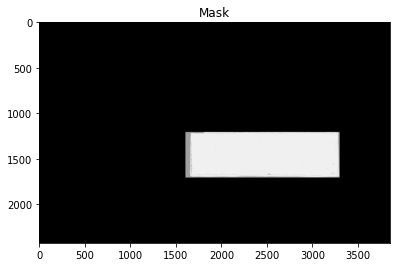

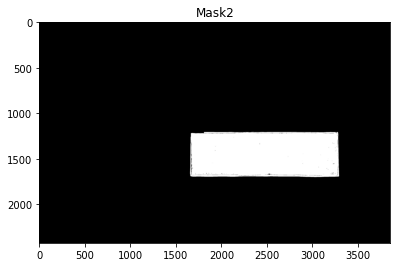

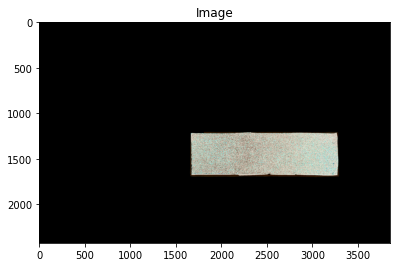

In [ ]:
# Let the algorithm run for 5 iterations. Mode should be cv.GC_INIT_WITH_RECT since we are using rectangle. 
# Grabcut modifies the mask image. 
# In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. 
# So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (i.e. background) & all 1-pixels and 3-pixels are put to 1(i.e. foreground pixels). 
# Now our final mask is ready. Just multiply it with input image to get the segmented image.
cv2.grabCut(image_side, mask_s, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask_s==2)|(mask_s==0),0,1).astype('uint8')
mask2 = mask2 * 255
image = image_side * mask2[:,:,np.newaxis]

imshow("Mask", mask_s * 80)
imshow("Mask2", mask2 )
imshow("Image", image)

no found
boxes: []
scores: []


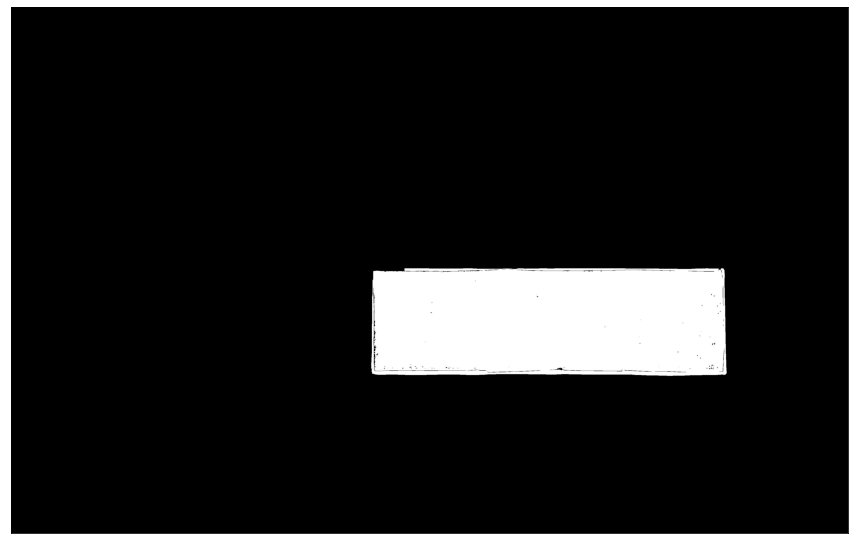

In [ ]:
# SECOND DETECTION

from PIL import Image
import numpy as np

img = Image.fromarray(mask2)
img.save('my.jpg')
img.show()

img_fp2='my.jpg'
boxes_f, pred_cls_f= object_detection_api(img_fp2, threshold=0.8)

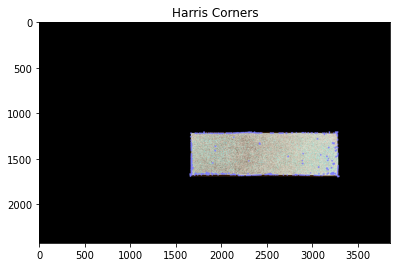

In [ ]:
harris_corners = cv2.cornerHarris(mask2, 3, 3, 0.05)

#We use dilation of the corner points to enlarge them\
kernel = np.ones((7,7),np.uint8)
harris_corners = cv2.dilate(harris_corners, kernel, iterations = 2)

# Threshold for an optimal value, it may vary depending on the image.
image[harris_corners > 0.9 * harris_corners.max() ] = [255, 127, 127]

imshow('Harris Corners', image)

In [ ]:
from PIL import Image
import numpy as np


img = Image.fromarray(mask2)
img.save('my.jpg')
img.show()

img=cv2.imread('my.jpg')

In [ ]:
#Second detection
boxes2, pred_cls2= object_detection_api(img, threshold=0.8)

AttributeError: ignored

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/thesis/cardboard/images"


#from google.colab import drive
#root = '/content/drive/'
#!ls root
#"/content/drive/thesis/cardboard"

#drive.mount(root)

#dboxdata="/content/drive/My Drive/thesis/cardboard/images/"
dboxdata="/content/drive/My Drive/thesis/normal/"
sys.path.append(dboxdata)

In [ ]:
# Example: Original picture before detection
list_dboxdata = os.listdir(dboxdata)  
list_dboxdata.sort()

img_ex_path = dboxdata + list_dboxdata[4]
print(img_ex_path)
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(np.real(img_ex))
plt.axis('off')
plt.show()